## Analyzing Open University Learning Analytics Dataset 

### Problem Statement 
## Data Modelling
Based on the given data of students enrolled in various courses identify the student who is at-risk so that suitable interventions can be taken to help students succeed. 

***Part-4 : Data Modelling and Prediction***

In this part we will try to model the data and predict the student at risk.

In [1]:
#importing Libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ML libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm.libsvm import predict_proba
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

In [2]:
# Reading Data
student_info = pd.read_csv('../studentInfo.csv')
student_assessment = pd.read_csv('../studentAssessment.csv')
student_registration = pd.read_csv('../studentRegistration.csv')
student_vle = pd.read_csv('../studentVle.csv')
assessments = pd.read_csv('../assessments.csv')
courses = pd.read_csv('../courses.csv')
vle = pd.read_csv('../vle.csv')

#check for the data
print('----- Rows -----')
print('Courses     : ',courses.shape[0])
print('Assessments : ',assessments.shape[0])
print('vle(Virtual Learning Environment) : ',vle.shape[0])
print('Student Info         : ',student_info.shape[0])
print('student Assessment   : ',student_assessment.shape[0])
print('student Registration : ',student_registration.shape[0])
print('student Vle          : ',student_vle.shape[0])

----- Rows -----
Courses     :  22
Assessments :  206
vle(Virtual Learning Environment) :  6364
Student Info         :  32593
student Assessment   :  173912
student Registration :  32593
student Vle          :  10655280


In [3]:
#Utilities
"""
Calculates sum based on the previous value
"""
def compute_weighted_sum(data, current_val, new_col):
    data[new_col] = data[current_val].cumsum()
    return data

In [4]:
"""
Get mean of the split data
"""
def split_mean(x):
    split_list = x.split('-')
    mean = (float(split_list[0])+float(split_list[1]))/2
    return mean

In [5]:
"""
Preprocessing Student_info
"""

def preprocess_student_info(data):
    data_pre = data.copy()
    data_pre['final_result'] = labelEncoder.fit_transform(data_pre['final_result'])
    #convert categorical columns 
    #----imd_band
    # Remove % first and replace '?' with 0 
    data_pre['imd_band'] =  data_pre['imd_band'].apply(lambda x : x.replace('%',''))
    data_pre['imd_band'] =  data_pre['imd_band'].apply(lambda x : '0' if x == '?' else x)
    #compute mean of the range and add them in seperate column
    data_pre['imd_band_mean'] = data_pre['imd_band'].apply(lambda x : 0 if x == '0' else split_mean(x))
    #----age_band
    # Replace '55<=' with 55 and other ranges with their mean 
    data_pre['age_band_mean'] =  data_pre['age_band'].apply(lambda x : 55 if x == '55<=' else split_mean(x))
    data_pre = data_pre[['code_module','code_presentation','id_student','gender','region','highest_education','num_of_prev_attempts','studied_credits','imd_band','imd_band_mean',
                         'age_band','age_band_mean','final_result']]
    return data_pre

In [6]:
#adding some more columns
assessments_stats = assessments.groupby(['code_module','code_presentation']).agg({'weight' : 'sum'})
assessments_stats.reset_index(level=[0,1], inplace=True)
assessments_stats.columns = ['code_module','code_presentation','total_marks']
assessments_stats = pd.merge(assessments, assessments_stats, how='left', on=['code_module','code_presentation'])
assessments_stats['percent_of_total'] = np.divide(assessments_stats['weight'],assessments_stats['total_marks'])*100
#assessments_stats.groupby(['code_module','code_presentation']).size()
assessments_stats = assessments_stats.groupby(['code_module','code_presentation']).apply(compute_weighted_sum, 'percent_of_total', 'weight_in_total')
student_assessments_all = pd.merge(student_assessment, assessments_stats, how = 'outer', on='id_assessment' )
# Dropping the null values
student_assessments_all = student_assessments_all.dropna()
student_assessments_all['score'] = np.where(student_assessments_all['score'] == '?', '0', student_assessments_all['score'])
student_assessments_all['score'] = pd.to_numeric(student_assessments_all['score'])
student_assessments_all['assessment_result'] = np.where(student_assessments_all['score'] >= 40, 1, 0)
student_assessments_all['score_weight'] = np.divide(student_assessments_all['score'],100)*student_assessments_all['percent_of_total']
student_assessments_all = student_assessments_all.dropna()
#student_assessments_all.id_student.nunique()
student_assessments_all = student_assessments_all.groupby(['code_module','code_presentation','id_student']).apply(compute_weighted_sum,'score_weight', 'score_in_total')
student_assessments_all = student_assessments_all[['code_module','code_presentation','id_student','id_assessment','assessment_type','date','date_submitted','is_banked',
                                                   'score','weight','percent_of_total','score_weight','weight_in_total','score_in_total','total_marks','assessment_result']]
#student_assessments_all[student_assessments_all['id_student'] == 63400]
student_assessments_all = student_assessments_all.dropna()
student_assessments_all[student_assessments_all['id_student'] == 63400]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,code_module,code_presentation,id_student,id_assessment,assessment_type,date,date_submitted,is_banked,score,weight,percent_of_total,score_weight,weight_in_total,score_in_total,total_marks,assessment_result
13,AAA,2013J,63400.0,1752,TMA,19.0,19.0,0.0,83.0,10.0,5.0,4.15,5.0,4.15,200.0,1
514,AAA,2013J,63400.0,1753,TMA,54.0,54.0,0.0,42.0,20.0,10.0,4.20,15.0,8.35,200.0,1
855,AAA,2013J,63400.0,1754,TMA,117.0,117.0,0.0,78.0,20.0,10.0,7.80,25.0,16.15,200.0,1
1045,AAA,2013J,63400.0,1755,TMA,166.0,166.0,0.0,76.0,20.0,10.0,7.60,35.0,23.75,200.0,1
1470,AAA,2013J,63400.0,1756,TMA,215.0,215.0,0.0,79.0,30.0,15.0,11.85,50.0,35.60,200.0,1


In [7]:

### ----  get ddata model
student_clicks = student_vle.groupby(['id_student', 'code_module', 'code_presentation']).agg({'sum_click':['mean','sum']})
student_clicks.reset_index(level=[0,1,2], inplace=True)
student_clicks.columns = ['id_student', 'code_module', 'code_presentation', 'mean_clicks', 'sum_clicks']
#student_clicks
# merging student_clicks with student info
student_course_info = pd.merge(student_info,student_clicks, how='left', left_on=['id_student', 'code_module', 'code_presentation'],right_on=['id_student', 'code_module',
                                                                                                                                             'code_presentation'])
student_course_info = student_course_info[['code_module','code_presentation','id_student','gender','region','highest_education','imd_band','age_band','num_of_prev_attempts',
                                           'studied_credits','disability','mean_clicks','sum_clicks','final_result']]
student_course_info.reset_index(level=[0], inplace=True)
student_course_info.head()

,index,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,mean_clicks,sum_clicks,final_result
0,0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,4.765306,934.0,Pass
1,1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,3.337209,1435.0,Pass
2,2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,3.697368,281.0,Withdrawn
3,3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,3.254902,2158.0,Pass
4,4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,2.937500,1034.0,Pass


In [8]:
dataset_demographic = student_course_info[['code_module','code_presentation','region','highest_education','imd_band','num_of_prev_attempts','studied_credits','disability','final_result']]
dataset_demographic.to_csv('../data/dataset_demographic.csv')
dataset_demographic.head()

,code_module,code_presentation,region,highest_education,imd_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,East Anglian Region,HE Qualification,90-100%,0,240,N,Pass
1,AAA,2013J,Scotland,HE Qualification,20-30%,0,60,N,Pass
2,AAA,2013J,North Western Region,A Level or Equivalent,30-40%,0,60,Y,Withdrawn
3,AAA,2013J,South East Region,A Level or Equivalent,50-60%,0,60,N,Pass
4,AAA,2013J,West Midlands Region,Lower Than A Level,50-60%,0,60,N,Pass


In [9]:
dataset_student_clicks = student_course_info[['code_module','code_presentation','id_student','gender','region','highest_education','imd_band','num_of_prev_attempts','studied_credits',
                                              'disability','sum_clicks','mean_clicks','final_result']]
dataset_student_clicks.to_csv('../data/dataset_student_clicks.csv')
dataset_student_clicks.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,num_of_prev_attempts,studied_credits,disability,sum_clicks,mean_clicks,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,0,240,N,934.0,4.765306,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,0,60,N,1435.0,3.337209,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,0,60,Y,281.0,3.697368,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,0,60,N,2158.0,3.254902,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0,60,N,1034.0,2.937500,Pass


### Calculating Assessments scores 

In [10]:
#adding some more columns
assessments_stats = assessments.groupby(['code_module','code_presentation']).agg({'weight' : 'sum'})
assessments_stats.reset_index(level=[0,1], inplace=True)
assessments_stats.head()


,code_module,code_presentation,weight
0,AAA,2013J,200.0
1,AAA,2014J,200.0
2,BBB,2013B,200.0
3,BBB,2013J,200.0
4,BBB,2014B,200.0


In [11]:
assessments_stats.columns = ['code_module','code_presentation','total_marks']
assessments_stats = pd.merge(assessments, assessments_stats, how='left', on=['code_module','code_presentation'])
assessments_stats['percent_of_total'] = np.divide(assessments_stats['weight'],assessments_stats['total_marks'])*100
assessments_stats.head()


,code_module,code_presentation,id_assessment,assessment_type,date,weight,total_marks,percent_of_total
0,AAA,2013J,1752,TMA,19.0,10.0,200.0,5.0
1,AAA,2013J,1753,TMA,54.0,20.0,200.0,10.0
2,AAA,2013J,1754,TMA,117.0,20.0,200.0,10.0
3,AAA,2013J,1755,TMA,166.0,20.0,200.0,10.0
4,AAA,2013J,1756,TMA,215.0,30.0,200.0,15.0


In [12]:
assessments_stats = assessments_stats.groupby(['code_module','code_presentation']).apply(compute_weighted_sum, 'percent_of_total', 'weight_in_total')
assessments_stats.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,total_marks,percent_of_total,weight_in_total
0,AAA,2013J,1752,TMA,19.0,10.0,200.0,5.0,5.0
1,AAA,2013J,1753,TMA,54.0,20.0,200.0,10.0,15.0
2,AAA,2013J,1754,TMA,117.0,20.0,200.0,10.0,25.0
3,AAA,2013J,1755,TMA,166.0,20.0,200.0,10.0,35.0
4,AAA,2013J,1756,TMA,215.0,30.0,200.0,15.0,50.0


In [13]:
student_assessments_all = pd.merge(student_assessment, assessments_stats, how = 'outer', on='id_assessment' )
student_assessments_all.isnull().sum()

id_assessment           0
id_student             18
date_submitted         18
is_banked              18
score                 191
code_module             0
code_presentation       0
assessment_type         0
date                 2873
weight                  0
total_marks             0
percent_of_total        0
weight_in_total         0
dtype: int64

In [14]:
#assessments_stats.groupby(['code_module','code_presentation']).size()

student_assessments_all = student_assessments_all.dropna()
student_assessments_all['score'] = np.where(student_assessments_all['score'] == '?', '0', student_assessments_all['score'])
student_assessments_all['score'] = pd.to_numeric(student_assessments_all['score'])
student_assessments_all['assessment_result'] = np.where(student_assessments_all['score'] >= 40, 1, 0)
student_assessments_all['score_weight'] = np.divide(student_assessments_all['score'],100)*student_assessments_all['percent_of_total']
# student_assessments_all = student_assessments_all.dropna()
student_assessments_all = student_assessments_all.groupby(['code_module','code_presentation','id_student']).apply(compute_weighted_sum,'score_weight', 'score_in_total')
student_assessments_all = student_assessments_all[['code_module','code_presentation','id_student','id_assessment','assessment_type','date','date_submitted','is_banked',
                                                   'score','weight','percent_of_total','score_weight','weight_in_total','score_in_total','total_marks','assessment_result']]
#student_assessments_all[student_assessments_all['id_student'] == 63400]

student_assessments_all = pd.merge(student_assessments_all, student_info[['id_student','final_result']], on='id_student')
student_assessments_all[student_assessments_all['id_student'] == 63400]

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,date_submitted,is_banked,score,weight,percent_of_total,score_weight,weight_in_total,score_in_total,total_marks,assessment_result,final_result
65,AAA,2013J,63400.0,1752,TMA,19.0,19.0,0.0,83.0,10.0,5.0,4.15,5.0,4.15,200.0,1,Pass
66,AAA,2013J,63400.0,1753,TMA,54.0,54.0,0.0,42.0,20.0,10.0,4.20,15.0,8.35,200.0,1,Pass
67,AAA,2013J,63400.0,1754,TMA,117.0,117.0,0.0,78.0,20.0,10.0,7.80,25.0,16.15,200.0,1,Pass
68,AAA,2013J,63400.0,1755,TMA,166.0,166.0,0.0,76.0,20.0,10.0,7.60,35.0,23.75,200.0,1,Pass
69,AAA,2013J,63400.0,1756,TMA,215.0,215.0,0.0,79.0,30.0,15.0,11.85,50.0,35.60,200.0,1,Pass


In [15]:
student_assessments_all.head()

,code_module,code_presentation,id_student,id_assessment,assessment_type,date,date_submitted,is_banked,score,weight,percent_of_total,score_weight,weight_in_total,score_in_total,total_marks,assessment_result,final_result
0,AAA,2013J,11391.0,1752,TMA,19.0,18.0,0.0,78.0,10.0,5.0,3.9,5.0,3.9,200.0,1,Pass
1,AAA,2013J,11391.0,1753,TMA,54.0,53.0,0.0,85.0,20.0,10.0,8.5,15.0,12.4,200.0,1,Pass
2,AAA,2013J,11391.0,1754,TMA,117.0,115.0,0.0,80.0,20.0,10.0,8.0,25.0,20.4,200.0,1,Pass
3,AAA,2013J,11391.0,1755,TMA,166.0,164.0,0.0,85.0,20.0,10.0,8.5,35.0,28.9,200.0,1,Pass
4,AAA,2013J,11391.0,1756,TMA,215.0,212.0,0.0,82.0,30.0,15.0,12.3,50.0,41.2,200.0,1,Pass


In [16]:
student_assessments_data = student_assessments_all[['code_module','code_presentation','id_student','id_assessment','assessment_type','is_banked','date','date_submitted','score','weight',
                                                    'weight_in_total','score_in_total','assessment_result','final_result']]
student_assessments_data.to_csv('../data/dataset_student_assessments.csv')
student_assessments_data[student_assessments_data['id_student'] == 63400]
student_assessments_data.shape

(203074, 14)

In [17]:
student_demographic_vle_clicks = dataset_student_clicks[['id_student','gender','region','highest_education','imd_band','num_of_prev_attempts','studied_credits','disability','sum_clicks',
                                                         'mean_clicks','final_result']]
student_data_final = pd.merge(student_demographic_vle_clicks, student_assessments_data, on=['id_student','final_result'])
student_data_final = student_data_final[['code_module', 'code_presentation', 'id_student', 'gender', 'region', 'highest_education', 'imd_band','num_of_prev_attempts', 'studied_credits', 
                                         'disability', 'sum_clicks', 'mean_clicks', 'id_assessment', 'assessment_type', 'is_banked', 'date', 'date_submitted', 'score', 'weight',
                                         'weight_in_total','score_in_total', 'assessment_result', 'final_result']]
#student_data_final.columns
student_data_final.to_csv('../data/dataset_student_final.csv')
student_data_final[student_data_final['id_student'] == 63400]
student_data_final.loc[:,{'id_student','highest_education','sum_clicks'}].head(10)


,sum_clicks,id_student,highest_education
0,934.0,11391,HE Qualification
1,934.0,11391,HE Qualification
2,934.0,11391,HE Qualification
3,934.0,11391,HE Qualification
4,934.0,11391,HE Qualification
5,1435.0,28400,HE Qualification
6,1435.0,28400,HE Qualification
7,1435.0,28400,HE Qualification
8,1435.0,28400,HE Qualification
9,1435.0,28400,HE Qualification


In [18]:
student_data_final

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,num_of_prev_attempts,studied_credits,disability,...,assessment_type,is_banked,date,date_submitted,score,weight,weight_in_total,score_in_total,assessment_result,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,0,240,N,...,TMA,0.0,19.0,18.0,78.0,10.0,5.0,3.90,1,Pass
1,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,0,240,N,...,TMA,0.0,54.0,53.0,85.0,20.0,15.0,12.40,1,Pass
2,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,0,240,N,...,TMA,0.0,117.0,115.0,80.0,20.0,25.0,20.40,1,Pass
3,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,0,240,N,...,TMA,0.0,166.0,164.0,85.0,20.0,35.0,28.90,1,Pass
4,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,0,240,N,...,TMA,0.0,215.0,212.0,82.0,30.0,50.0,41.20,1,Pass
5,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,0,60,N,...,TMA,0.0,19.0,22.0,70.0,10.0,5.0,3.50,1,Pass
6,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,0,60,N,...,TMA,0.0,54.0,52.0,68.0,20.0,15.0,10.30,1,Pass
7,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,0,60,N,...,TMA,0.0,117.0,121.0,70.0,20.0,25.0,17.30,1,Pass
8,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,0,60,N,...,TMA,0.0,166.0,164.0,64.0,20.0,35.0,23.70,1,Pass
9,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,0,60,N,...,TMA,0.0,215.0,212.0,60.0,30.0,50.0,32.70,1,Pass


In [19]:
allwithdrawn=student_data_final[student_data_final['final_result']=='Withdrawn']
allwithdrawn

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,num_of_prev_attempts,studied_credits,disability,...,assessment_type,is_banked,date,date_submitted,score,weight,weight_in_total,score_in_total,assessment_result,final_result
70,AAA,2013J,65002,F,East Anglian Region,A Level or Equivalent,70-80%,0,60,N,...,TMA,0.0,19.0,17.0,66.0,10.0,5.0,3.30,1,Withdrawn
71,AAA,2013J,65002,F,East Anglian Region,A Level or Equivalent,70-80%,0,60,N,...,TMA,0.0,54.0,51.0,68.0,20.0,15.0,10.10,1,Withdrawn
72,AAA,2014J,65002,F,East Anglian Region,A Level or Equivalent,70-80%,0,60,N,...,TMA,1.0,19.0,-1.0,66.0,10.0,5.0,3.30,1,Withdrawn
73,AAA,2014J,65002,F,East Anglian Region,A Level or Equivalent,70-80%,0,60,N,...,TMA,1.0,54.0,-1.0,68.0,20.0,15.0,10.10,1,Withdrawn
103,AAA,2013J,94961,M,South Region,Lower Than A Level,70-80%,0,60,N,...,TMA,0.0,19.0,17.0,74.0,10.0,5.0,3.70,1,Withdrawn
104,AAA,2014J,94961,M,South Region,Lower Than A Level,70-80%,0,60,N,...,TMA,1.0,19.0,-1.0,74.0,10.0,5.0,3.70,1,Withdrawn
105,AAA,2014J,94961,M,South Region,Lower Than A Level,70-80%,0,60,N,...,TMA,0.0,54.0,51.0,67.0,20.0,15.0,10.40,1,Withdrawn
106,AAA,2014J,94961,M,South Region,Lower Than A Level,70-80%,0,60,N,...,TMA,0.0,117.0,122.0,57.0,20.0,25.0,16.10,1,Withdrawn
107,AAA,2014J,94961,M,South Region,Lower Than A Level,70-80%,0,60,N,...,TMA,0.0,166.0,166.0,65.0,20.0,35.0,22.60,1,Withdrawn
108,AAA,2014J,94961,M,South Region,Lower Than A Level,70-80%,0,60,N,...,TMA,0.0,215.0,211.0,55.0,30.0,50.0,30.85,1,Withdrawn


In [20]:
allwithdrawn.shape

(33167, 23)

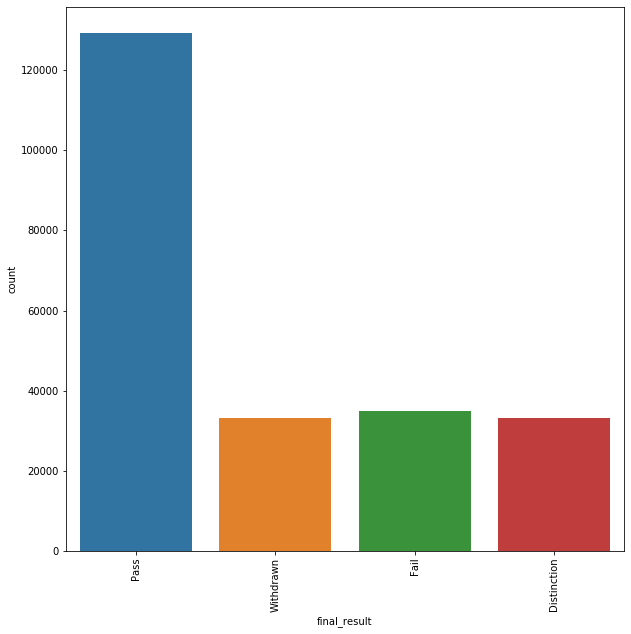

In [21]:
plt.figure(figsize=(10,10))
sns.countplot(student_data_final.final_result)
plt.xticks(rotation = 90)
plt.show()

In [22]:
dft = {'Pass':25095, 'Withdrawn':4693, 'Fail':4688, 'Distinction':5919}
df = pd.DataFrame(data=dft,index=dft.keys())
df.head()

,Pass,Withdrawn,Fail,Distinction
Pass,25095,4693,4688,5919
Withdrawn,25095,4693,4688,5919
Fail,25095,4693,4688,5919
Distinction,25095,4693,4688,5919
